In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#previous = pd.read_csv("/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk/previous_application.csv")
#installments = pd.read_csv("/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk/installments_payments.csv")
#pos = pd.read_csv("/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk/POS_CASH_balance.csv")
application_df = pd.read_csv("/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk/application_train.csv")
#credit = pd.read_csv("/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk/credit_card_balance.csv")

# Application data set 

In [153]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [154]:
pd.options.display.max_rows = 200
application_df.isna().mean()*100

SK_ID_CURR                       0.000000
TARGET                           0.000000
NAME_CONTRACT_TYPE               0.000000
CODE_GENDER                      0.000000
FLAG_OWN_CAR                     0.000000
FLAG_OWN_REALTY                  0.000000
CNT_CHILDREN                     0.000000
AMT_INCOME_TOTAL                 0.000000
AMT_CREDIT                       0.000000
AMT_ANNUITY                      0.003902
AMT_GOODS_PRICE                  0.090403
NAME_TYPE_SUITE                  0.420148
NAME_INCOME_TYPE                 0.000000
NAME_EDUCATION_TYPE              0.000000
NAME_FAMILY_STATUS               0.000000
NAME_HOUSING_TYPE                0.000000
REGION_POPULATION_RELATIVE       0.000000
DAYS_BIRTH                       0.000000
DAYS_EMPLOYED                    0.000000
DAYS_REGISTRATION                0.000000
DAYS_ID_PUBLISH                  0.000000
OWN_CAR_AGE                     65.990810
FLAG_MOBIL                       0.000000
FLAG_EMP_PHONE                   0

## Data Preparation & Cleaning

### CAR_OWN_AGE new feature

Here I created a new feature called "CAR_AGE_BIN" where "new", "old", "quite old", "very old" bins exist, which corresponde to 25th, median, 75th, and above 75th percentile respectively. "none" is for no car being owned.

In [158]:
# Convert OWN_CAR_AGE to float32 to avoid float16 issues
application_df["OWN_CAR_AGE"] = application_df["OWN_CAR_AGE"].astype("float32")

# Apply pd.cut() after ensuring the correct dtype
# Apply pd.cut(), making a new feature
application_df["CAR_AGE_BIN"] = pd.cut(application_df["OWN_CAR_AGE"], 
                             labels=["new", "old", "quite old", "very old"], 
                             bins=[0, application_df["OWN_CAR_AGE"].quantile(0.25), 
                                   application_df["OWN_CAR_AGE"].median(), 
                                   application_df["OWN_CAR_AGE"].quantile(0.75), 
                                   application_df["OWN_CAR_AGE"].max()])

# For rows that were originally missing, assign 'none' explicitly
application_df["CAR_AGE_BIN"] = application_df["CAR_AGE_BIN"].cat.add_categories("none")  # Add "none" as a category
application_df["CAR_AGE_BIN"] = application_df["CAR_AGE_BIN"].fillna("none")  

# Show the result
print(application_df[['OWN_CAR_AGE', 'CAR_AGE_BIN']])

        OWN_CAR_AGE CAR_AGE_BIN
0               NaN        none
1               NaN        none
2              26.0    very old
3               NaN        none
4               NaN        none
...             ...         ...
307506          NaN        none
307507          NaN        none
307508          NaN        none
307509          NaN        none
307510          NaN        none

[307511 rows x 2 columns]


Next I factored it so ml models could be used better.

In [160]:
#Factorized the 'CAR_AGE_BIN'
application_df['CAR_AGE_BIN'] = pd.Categorical(application_df['CAR_AGE_BIN'], categories=["none", "very old", "quite old", "old", "new"], \
                                               ordered=True) #order of value matter
application_df["CAR_AGE_BIN_Factorized"], _ = pd.factorize(application_df["CAR_AGE_BIN"])
application_df.drop(columns=["CAR_AGE_BIN"], inplace=True)


In [161]:
print(application_df["CAR_AGE_BIN_Factorized"].head(25))

0     0
1     0
2     1
3     0
4     0
5     0
6     1
7     2
8     0
9     0
10    0
11    0
12    0
13    1
14    0
15    1
16    0
17    0
18    0
19    0
20    2
21    3
22    0
23    0
24    2
Name: CAR_AGE_BIN_Factorized, dtype: int64


### OCCUPATION TYPE filling NAs

Here I filled missing occupations with "Others" for NAs.

In [164]:
#Change the missing occupations to others
application_df["OCCUPATION_TYPE"] = application_df["OCCUPATION_TYPE"].fillna("Others")

#Get the count for each occupations
application_df["OCCUPATION_TYPE"].value_counts()

OCCUPATION_TYPE
Others                   96391
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

### EXTERNAL sources

Used Sudeeptha's function for external sources factorized and fillna() with 0. 

In [167]:
def factorize_application(df):
    bins = [0, 0.3, 0.6, 0.8, 1.0]
    labels = ['Very Poor', 'Average', 'Good', 'Excellent']

    # Replacing NaN values with 0
    for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        df[col] = df[col].fillna(0).astype('float32')  
    
    # Binning and creating new category columns
    for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        df[col + '_Category'] = pd.cut(df[col], bins=bins, labels=labels, right=False)
    
    # Dropping original EXT_SOURCE columns
    df.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace = True)
    
    # Factorizing the category columns
    for col in ['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']:
        df[col] = pd.factorize(df[col])[0]

    print(f"Factorized Columns: {['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']}")
    return df

In [168]:
factorize_application(application_df)

Factorized Columns: ['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CAR_AGE_BIN_Factorized,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,2,1
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0,2,2,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,1


In [169]:
print(application_df[['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']].head(5))

   EXT_SOURCE_1_Category  EXT_SOURCE_2_Category  EXT_SOURCE_3_Category
0                      0                      0                      0
1                      1                      1                      0
2                      0                      2                      1
3                      0                      1                      0
4                      0                      2                      0


### Data Cleaning

In [171]:
# filtering the data that has missing values > 65%
def dropna_over65(df):
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing_values / len(df) * 100)

    missing_data_over_65 = missing_percent[missing_percent > 65]
    print(f'There are: {len(missing_data_over_65)} columns missing data over 65%')
    print(missing_data_over_65)

#dropping columns that have more than 65% null values
    df.drop(columns = missing_data_over_65.index, inplace=True)
    print('\n')
    print(f'Shape of the df after removing missing data over 65% : {df.shape}')
    
    return df 

In [172]:
application_df = dropna_over65(application_df)

There are: 17 columns missing data over 65%
COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
FLOORSMIN_AVG               67.848630
FLOORSMIN_MEDI              67.848630
FLOORSMIN_MODE              67.848630
YEARS_BUILD_MODE            66.497784
YEARS_BUILD_AVG             66.497784
YEARS_BUILD_MEDI            66.497784
OWN_CAR_AGE                 65.990810
dtype: float64


Shape of the df after removing missing data over 65% : (307511, 106)


### Dropping other unnecessary columns

In [174]:
# Drop columns whose name contains 'FLAG_DOCUMENT'
application_df = application_df.loc[:, ~application_df.columns.str.contains('FLAG_DOCUMENT')]

columns_to_drop = [
    'NAME_TYPE_SUITE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'WEEKDAY_APPR_PROCESS_START',
    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'APARTMENTS_AVG', 'YEARS_BUILD_AVG', 
    'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 
    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 
    'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
    'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
    'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DAYS_LAST_PHONE_CHANGE', 'REG_REGION_NOT_LIVE_REGION'
]

# Drop unwanted columns from the DataFrame
application_df = application_df.drop(columns=columns_to_drop, errors='ignore')

# Show the updated DataFrame
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_INCOME_TYPE             307511 non-null  object 
 12  NAME_EDUCATION_TYPE          307511 non-null  object 
 13 

### Scalling for numeric columns 

In [176]:
# scale
from sklearn.preprocessing import StandardScaler

# List of columns to exclude from standardization
exclude_columns = ['TARGET',
    'CAR_AGE_BIN_Factorized', 'EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 
    'EXT_SOURCE_3_Category', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 
    'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'ORGANIZATION_TYPE'
]

# Exclude the specified columns from the numeric columns
columns_to_standardize = [col for col in application_df.columns if col not in exclude_columns]

# Print the columns to standardize
print("Columns to standardize:", columns_to_standardize)

# Apply standardization using StandardScaler
scaler = StandardScaler()
application_df[columns_to_standardize] = scaler.fit_transform(application_df[columns_to_standardize])

# Verify the changes
application_df.head()

Columns to standardize: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CAR_AGE_BIN_Factorized,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category
0,100002,1,Cash loans,M,N,Y,-0.577538,0.142129,-0.478095,-0.166146,...,-0.076357,-0.063203,-0.167878,-0.291916,-0.334328,-0.481452,0,0,0,0
1,100003,0,Cash loans,F,N,N,-0.577538,0.426792,1.725450,0.592666,...,-0.076357,-0.063203,-0.167878,-0.291916,-0.334328,-1.016414,0,1,1,0
2,100004,0,Revolving loans,M,Y,Y,-0.577538,-0.427196,-1.152888,-1.404649,...,-0.076357,-0.063203,-0.167878,-0.291916,-0.334328,-1.016414,1,0,2,1
3,100006,0,Cash loans,F,N,Y,-0.577538,-0.142533,-0.711430,0.177865,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
4,100007,0,Cash loans,M,N,Y,-0.577538,-0.199466,-0.213734,-0.361748,...,-0.076357,-0.063203,-0.167878,-0.291916,-0.334328,-1.016414,0,0,2,0


### Impute NAs

In [178]:
def imputing_na(df):
    for col in df.columns:
        if not df[col].dtype == 'number':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    print("Imputed all na values")
    return df

In [179]:
application_df = imputing_na(application_df)

Imputed all na values


In [180]:
application_df.isna().sum()

SK_ID_CURR                     0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_CONT_MOBILE               0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
REG_CITY_NOT_LIVE_CITY         0
ORGANIZATION_TYPE              0
APARTMENTS_MODE                0
APARTMENTS

In [181]:
application_df.shape

(307511, 45)

### Downsampling

In [183]:
# Separate majority and minority classes
majority_class = application_df[application_df["TARGET"] == 0]  # class 0 is the majority
minority_class = application_df[application_df["TARGET"] == 1]  # class 1 is the minority

# Downsample the majority class
majority_downsampled = resample(majority_class, 
                                replace=False,  # No replacement, just subsampling
                                n_samples=len(minority_class),  # Match the minority class size
                                random_state=42)  # Ensures reproducibility

# Combine minority class with downsampled majority class
application_df_down_sampled = pd.concat([majority_downsampled, minority_class])

# Shuffle the dataset
application_df_down_sampled = application_df_down_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
print(application_df_down_sampled.shape)

(49650, 45)


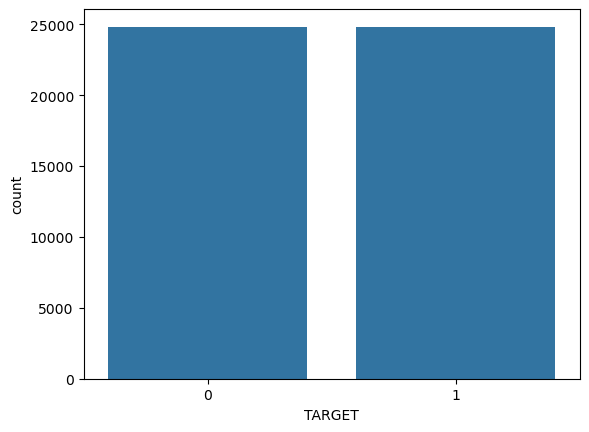

In [184]:
sns.countplot(application_df_down_sampled, x="TARGET")
plt.show()

The data is downsampled, number of 0 and 1 is the same.

In [186]:
application_df_down_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49650 entries, 0 to 49649
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   49650 non-null  int64  
 1   TARGET                       49650 non-null  int64  
 2   NAME_CONTRACT_TYPE           49650 non-null  object 
 3   CODE_GENDER                  49650 non-null  object 
 4   FLAG_OWN_CAR                 49650 non-null  object 
 5   FLAG_OWN_REALTY              49650 non-null  object 
 6   CNT_CHILDREN                 49650 non-null  float64
 7   AMT_INCOME_TOTAL             49650 non-null  float64
 8   AMT_CREDIT                   49650 non-null  float64
 9   AMT_ANNUITY                  49650 non-null  float64
 10  AMT_GOODS_PRICE              49650 non-null  float64
 11  NAME_INCOME_TYPE             49650 non-null  object 
 12  NAME_EDUCATION_TYPE          49650 non-null  object 
 13  NAME_FAMILY_STAT

No more NAs, 49649 rows, 45 columns 

In [188]:
#Write the final data
#application_df_down_sampled.to_csv("application_final.csv", index=False)

# Previous application joining

### High View of data

In [191]:
#Load data
previous_df = pd.read_csv("/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk/previous_application.csv")
final_application_df = pd.read_csv("/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk/application_final.csv")

In [192]:
previous_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [193]:
previous_df.isna().mean()*100

SK_ID_PREV                      0.000000
SK_ID_CURR                      0.000000
NAME_CONTRACT_TYPE              0.000000
AMT_ANNUITY                    22.286665
AMT_APPLICATION                 0.000000
AMT_CREDIT                      0.000060
AMT_DOWN_PAYMENT               53.636480
AMT_GOODS_PRICE                23.081773
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
FLAG_LAST_APPL_PER_CONTRACT     0.000000
NFLAG_LAST_APPL_IN_DAY          0.000000
RATE_DOWN_PAYMENT              53.636480
RATE_INTEREST_PRIMARY          99.643698
RATE_INTEREST_PRIVILEGED       99.643698
NAME_CASH_LOAN_PURPOSE          0.000000
NAME_CONTRACT_STATUS            0.000000
DAYS_DECISION                   0.000000
NAME_PAYMENT_TYPE               0.000000
CODE_REJECT_REASON              0.000000
NAME_TYPE_SUITE                49.119754
NAME_CLIENT_TYPE                0.000000
NAME_GOODS_CATEGORY             0.000000
NAME_PORTFOLIO                  0.000000
NAME_PRODUCT_TYP

### DAYS_ and NFLAG_ columns

Looks like "DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_LAST_DUE_1ST_VERSION","DAYS_LAST_DUE", "DAYS_TERMINATION","NFLAG_INSURED_ON_APPROVAL" are having the same missingness, lets investiage this. 

In [196]:
#Check if NA for this group happens accross columns
previous_df[previous_df[["DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_LAST_DUE_1ST_VERSION","DAYS_LAST_DUE", \
             "DAYS_TERMINATION","NFLAG_INSURED_ON_APPROVAL"]].isna()==True].head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Suspecting this is happening because the "NAME_CONTRACT_STATUS" is "Refused" and "Canceled"

In [198]:
previous_df[["NAME_CONTRACT_STATUS","DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_LAST_DUE_1ST_VERSION","DAYS_LAST_DUE", \
             "DAYS_TERMINATION","NFLAG_INSURED_ON_APPROVAL"]].head(50)

,NAME_CONTRACT_STATUS,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,Approved,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,Approved,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,Approved,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,Approved,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,Refused,NaN,NaN,NaN,NaN,NaN,NaN
5,Approved,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,Canceled,NaN,NaN,NaN,NaN,NaN,NaN
7,Canceled,NaN,NaN,NaN,NaN,NaN,NaN
8,Canceled,NaN,NaN,NaN,NaN,NaN,NaN
9,Canceled,NaN,NaN,NaN,NaN,NaN,NaN


The data seems to litterd with placeholdes "365243.0" and inconsistent values. My best strategy: drop columns.

In [200]:
#Drop these columns
previous_df.drop(columns=["DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_LAST_DUE_1ST_VERSION","DAYS_LAST_DUE", \
             "DAYS_TERMINATION","NFLAG_INSURED_ON_APPROVAL"], inplace=True)

### "RATE_DOWN_PAYMENT"and "AMT_DOWN_PAYMENT" by "NAME_CONTRACT_TYPE"

In [202]:
previous_df[["RATE_DOWN_PAYMENT","AMT_DOWN_PAYMENT","NAME_CONTRACT_TYPE"]].head(20)

,RATE_DOWN_PAYMENT,AMT_DOWN_PAYMENT,NAME_CONTRACT_TYPE
0,0.000000,0.0,Consumer loans
1,NaN,NaN,Cash loans
2,NaN,NaN,Cash loans
3,NaN,NaN,Cash loans
4,NaN,NaN,Cash loans
5,NaN,NaN,Cash loans
6,NaN,NaN,Cash loans
7,NaN,NaN,Cash loans
8,NaN,NaN,Cash loans
9,NaN,NaN,Cash loans


In [203]:
#Check missingness for each categorical values
previous_df.groupby("NAME_CONTRACT_TYPE")[["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]].apply(lambda x: x.isna().mean())

,RATE_DOWN_PAYMENT,AMT_DOWN_PAYMENT
NAME_CONTRACT_TYPE,,
Cash loans,0.935879,0.935879
Consumer loans,0.007008,0.007008
Revolving loans,0.987601,0.987601
XNA,1.000000,1.000000


In [204]:
#Drop rows where contract type is "XNA" if they are not valid
previous_df = previous_df[previous_df["NAME_CONTRACT_TYPE"] != "XNA"]

#Change "Cash loans", "Revolving loans" NAs to 0
previous_df.loc[previous_df["NAME_CONTRACT_TYPE"].isin(["Cash loans", "Revolving loans"]), 
                ["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]] = 0

#Fill missing with median for "Consumer loans"
consumer_median = previous_df.loc[previous_df["NAME_CONTRACT_TYPE"] == "Consumer loans", 
                                  ["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]].median()
previous_df.loc[previous_df["NAME_CONTRACT_TYPE"] == "Consumer loans", 
                ["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]] = previous_df.loc[
    previous_df["NAME_CONTRACT_TYPE"] == "Consumer loans", 
    ["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]
].fillna(consumer_median)

In [205]:
previous_df.groupby("NAME_CONTRACT_TYPE")[["RATE_DOWN_PAYMENT", "AMT_DOWN_PAYMENT"]].apply(lambda x: x.isna().mean())


,RATE_DOWN_PAYMENT,AMT_DOWN_PAYMENT
NAME_CONTRACT_TYPE,,
Cash loans,0.0,0.0
Consumer loans,0.0,0.0
Revolving loans,0.0,0.0


### "NAME_TYPE_SUITE"

In [207]:
#Check for values in this column
previous_df["NAME_TYPE_SUITE"] = previous_df["NAME_TYPE_SUITE"].astype("category")
print(previous_df["NAME_TYPE_SUITE"].cat.categories)


Index(['Children', 'Family', 'Group of people', 'Other_A', 'Other_B',
       'Spouse, partner', 'Unaccompanied'],
      dtype='object')


In [208]:
#Fillna with 'Other'
previous_df["NAME_TYPE_SUITE"] = previous_df["NAME_TYPE_SUITE"].cat.add_categories("Other")
previous_df["NAME_TYPE_SUITE"] = previous_df["NAME_TYPE_SUITE"].fillna("Other")

### Drop PRODUCT_COMBINATION

This columns has already been captured by "NAME_PRODUCT_TYPE","NAME_CONTRACT_TYPE","NAME_YIELD_GROUP" combinations.

In [211]:
previous_df[["NAME_PRODUCT_TYPE","NAME_CONTRACT_TYPE","NAME_YIELD_GROUP","PRODUCT_COMBINATION"]].head(10)

,NAME_PRODUCT_TYPE,NAME_CONTRACT_TYPE,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,XNA,Consumer loans,middle,POS mobile with interest
1,x-sell,Cash loans,low_action,Cash X-Sell: low
2,x-sell,Cash loans,high,Cash X-Sell: high
3,x-sell,Cash loans,middle,Cash X-Sell: middle
4,walk-in,Cash loans,high,Cash Street: high
5,x-sell,Cash loans,low_normal,Cash X-Sell: low
6,XNA,Cash loans,XNA,Cash
7,XNA,Cash loans,XNA,Cash
8,XNA,Cash loans,XNA,Cash
9,XNA,Cash loans,XNA,Cash


In [212]:
previous_df.drop("PRODUCT_COMBINATION", axis=1, inplace=True)

### Delete column with >65 missing

In [214]:
print(dropna_over65(previous_df).head())

There are: 2 columns missing data over 65%
RATE_INTEREST_PRIVILEGED    99.643625
RATE_INTEREST_PRIMARY       99.643625
dtype: float64


Shape of the df after removing missing data over 65% : (1669868, 28)
   SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               0.0         607500.0                   THURSDAY   
2    136444.5               0.0         112500.0                    TUESDAY   
3    47079

In [272]:
#Write
#previous_df.to_csv("previous_cleaned.csv", index=False)

### Aggregate before joining

In [216]:
previous_df['SK_ID_CURR'].nunique()

338857

There are 338857 unique applicants. Then with a total of 1670214 rows, there is approximately 5 applications per client. It is important to aggreagte the previous_df, or joining will implode with duplicate informations. 

In [218]:
# Explicitly convert numeric columns
numeric_cols = [
    "AMT_ANNUITY", 
    "AMT_GOODS_PRICE", 
    "CNT_PAYMENT"
]

for col in numeric_cols:
    previous_df[col] = pd.to_numeric(previous_df[col], errors='coerce')

# Simplified aggregation dictionary
agg_dict = {
    "SK_ID_PREV": "count",
    "AMT_ANNUITY": ["median", "sum"],
    "AMT_GOODS_PRICE": ["median", "sum"],
    "CNT_PAYMENT": "median",
    "NAME_CONTRACT_TYPE": lambda x: x.mode().iloc[0],
    "NAME_CASH_LOAN_PURPOSE": lambda x: x.mode().iloc[0],
    "NAME_PAYMENT_TYPE": lambda x: x.mode().iloc[0]
}

# Perform aggregation
previous_agg = previous_df.groupby("SK_ID_CURR").agg(agg_dict).reset_index()

# Flatten MultiIndex columns
previous_agg.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in previous_agg.columns.values]

# Fill NaNs for numeric columns with 0
previous_agg[["AMT_ANNUITY_median", "AMT_GOODS_PRICE_median", "CNT_PAYMENT_median"]] = previous_agg[["AMT_ANNUITY_median", "AMT_GOODS_PRICE_median", "CNT_PAYMENT_median"]].fillna(0)

print(previous_agg.head())

   SK_ID_CURR  SK_ID_PREV_count  AMT_ANNUITY_median  AMT_ANNUITY_sum  \
0      100001                 1            3951.000         3951.000   
1      100002                 1            9251.775         9251.775   
2      100003                 3           64567.665       169661.970   
3      100004                 1            5357.250         5357.250   
4      100005                 2            4813.200         4813.200   

   AMT_GOODS_PRICE_median  AMT_GOODS_PRICE_sum  CNT_PAYMENT_median  \
0                 24835.5              24835.5                 8.0   
1                179055.0             179055.0                24.0   
2                337500.0            1306309.5                12.0   
3                 24282.0              24282.0                 4.0   
4                 44617.5              44617.5                12.0   

  NAME_CONTRACT_TYPE_<lambda> NAME_CASH_LOAN_PURPOSE_<lambda>  \
0              Consumer loans                             XAP   
1              C

In [219]:
previous_agg[["AMT_ANNUITY_median", "AMT_GOODS_PRICE_median", "CNT_PAYMENT_median"]] = previous_agg[["AMT_ANNUITY_median", "AMT_GOODS_PRICE_median", "CNT_PAYMENT_median"]].fillna(0)
print(previous_agg.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338857 entries, 0 to 338856
Data columns (total 10 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   SK_ID_CURR                       338857 non-null  int64  
 1   SK_ID_PREV_count                 338857 non-null  int64  
 2   AMT_ANNUITY_median               338857 non-null  float64
 3   AMT_ANNUITY_sum                  338857 non-null  float64
 4   AMT_GOODS_PRICE_median           338857 non-null  float64
 5   AMT_GOODS_PRICE_sum              338857 non-null  float64
 6   CNT_PAYMENT_median               338857 non-null  float64
 7   NAME_CONTRACT_TYPE_<lambda>      338857 non-null  object 
 8   NAME_CASH_LOAN_PURPOSE_<lambda>  338857 non-null  object 
 9   NAME_PAYMENT_TYPE_<lambda>       338857 non-null  object 
dtypes: float64(5), int64(2), object(3)
memory usage: 25.9+ MB
None


Before we have 1670214 rows, now 338857 (individual level). 37 columns to 10. 

In [221]:
previous_agg.head()

,SK_ID_CURR,SK_ID_PREV_count,AMT_ANNUITY_median,AMT_ANNUITY_sum,AMT_GOODS_PRICE_median,AMT_GOODS_PRICE_sum,CNT_PAYMENT_median,NAME_CONTRACT_TYPE_<lambda>,NAME_CASH_LOAN_PURPOSE_<lambda>,NAME_PAYMENT_TYPE_<lambda>
0,100001,1,3951.000,3951.000,24835.5,24835.5,8.0,Consumer loans,XAP,Cash through the bank
1,100002,1,9251.775,9251.775,179055.0,179055.0,24.0,Consumer loans,XAP,XNA
2,100003,3,64567.665,169661.970,337500.0,1306309.5,12.0,Consumer loans,XAP,Cash through the bank
3,100004,1,5357.250,5357.250,24282.0,24282.0,4.0,Consumer loans,XAP,Cash through the bank
4,100005,2,4813.200,4813.200,44617.5,44617.5,12.0,Cash loans,XAP,Cash through the bank


### Joining

In [224]:
previous_and_app_df = final_application_df.merge(previous_agg, on="SK_ID_CURR", how="left")
previous_and_app_df.head(20)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3_Category,SK_ID_PREV_count,AMT_ANNUITY_median,AMT_ANNUITY_sum,AMT_GOODS_PRICE_median,AMT_GOODS_PRICE_sum,CNT_PAYMENT_median,NAME_CONTRACT_TYPE_<lambda>,NAME_CASH_LOAN_PURPOSE_<lambda>,NAME_PAYMENT_TYPE_<lambda>
0,343403,0,Cash loans,M,N,Y,-0.577538,-0.332309,-0.359080,-0.119574,...,1,1.0,8311.8150,8311.815,154836.00,154836.0,24.0,Consumer loans,XAP,Cash through the bank
1,239949,0,Cash loans,F,N,N,-0.577538,-0.408219,-0.752182,-0.761646,...,0,1.0,7928.1450,7928.145,45180.00,45180.0,6.0,Consumer loans,XAP,Cash through the bank
2,340073,0,Cash loans,F,N,N,-0.577538,-0.294354,-0.781699,-0.584051,...,0,2.0,4898.9475,9797.895,36110.25,72220.5,10.0,Consumer loans,XAP,Cash through the bank
3,442204,0,Cash loans,F,N,Y,-0.577538,-0.237421,-0.722733,-0.708243,...,0,14.0,9742.5900,49438.980,83250.00,487350.0,9.0,Cash loans,XNA,XNA
4,443323,0,Cash loans,F,Y,Y,-0.577538,1.185892,-0.237918,2.065580,...,1,6.0,12234.8925,98205.795,177952.50,1064155.5,9.0,Consumer loans,XAP,Cash through the bank
5,443800,1,Cash loans,F,N,N,-0.577538,-0.351286,0.649974,0.053984,...,2,3.0,6471.3600,19799.505,47196.00,140886.0,12.0,Consumer loans,XAP,Cash through the bank
6,390863,1,Cash loans,F,Y,Y,0.807273,0.142129,-0.575510,-0.146586,...,0,3.0,3274.7850,6549.570,20497.50,40995.0,9.0,Consumer loans,XAP,XNA
7,331967,0,Cash loans,F,N,Y,0.807273,1.565443,0.788700,0.378745,...,0,10.0,66792.7125,702350.055,678339.00,6663861.0,8.0,Consumer loans,XAP,Cash through the bank
8,243360,1,Cash loans,F,N,Y,-0.577538,-0.237421,0.393976,1.057143,...,2,4.0,13271.4225,55469.565,144270.00,536040.0,14.0,Cash loans,XAP,Cash through the bank
9,445763,0,Cash loans,M,Y,Y,0.807273,0.274972,-1.302884,-1.315851,...,1,2.0,18947.4300,37894.860,184232.25,368464.5,10.0,Consumer loans,XAP,Cash through the bank


In [225]:
previous_and_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49650 entries, 0 to 49649
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SK_ID_CURR                       49650 non-null  int64  
 1   TARGET                           49650 non-null  int64  
 2   NAME_CONTRACT_TYPE               49650 non-null  object 
 3   CODE_GENDER                      49650 non-null  object 
 4   FLAG_OWN_CAR                     49650 non-null  object 
 5   FLAG_OWN_REALTY                  49650 non-null  object 
 6   CNT_CHILDREN                     49650 non-null  float64
 7   AMT_INCOME_TOTAL                 49650 non-null  float64
 8   AMT_CREDIT                       49650 non-null  float64
 9   AMT_ANNUITY                      49650 non-null  float64
 10  AMT_GOODS_PRICE                  49650 non-null  float64
 11  NAME_INCOME_TYPE                 49650 non-null  object 
 12  NAME_EDUCATION_TYP

In [226]:
#Write the new df
#previous_and_app_df.to_csv("application_and_previous.csv", index=False)